# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [1]:
import pandas as pd
from src.sim.scenario import Scenario
from src.metrics import MetricsProcessor
from src.plotting.sim import plot_prices
from src.configs import SYMBOL_TO_ADDRESS

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

[INFO][21:41:38][src.sim.scenario]-81440: Fetching sim_market from subgraph.


[INFO][21:41:46][src.sim.scenario]-81440: Using 148320 1Inch quotes from 2023-12-06 20:41:41.428785 to 2023-12-13 20:41:41.428785
[INFO][21:41:46][src.utils.poolgraph]-81440: Found 20 valid cycles of length 3.


Running 168 steps with frequency 1h.


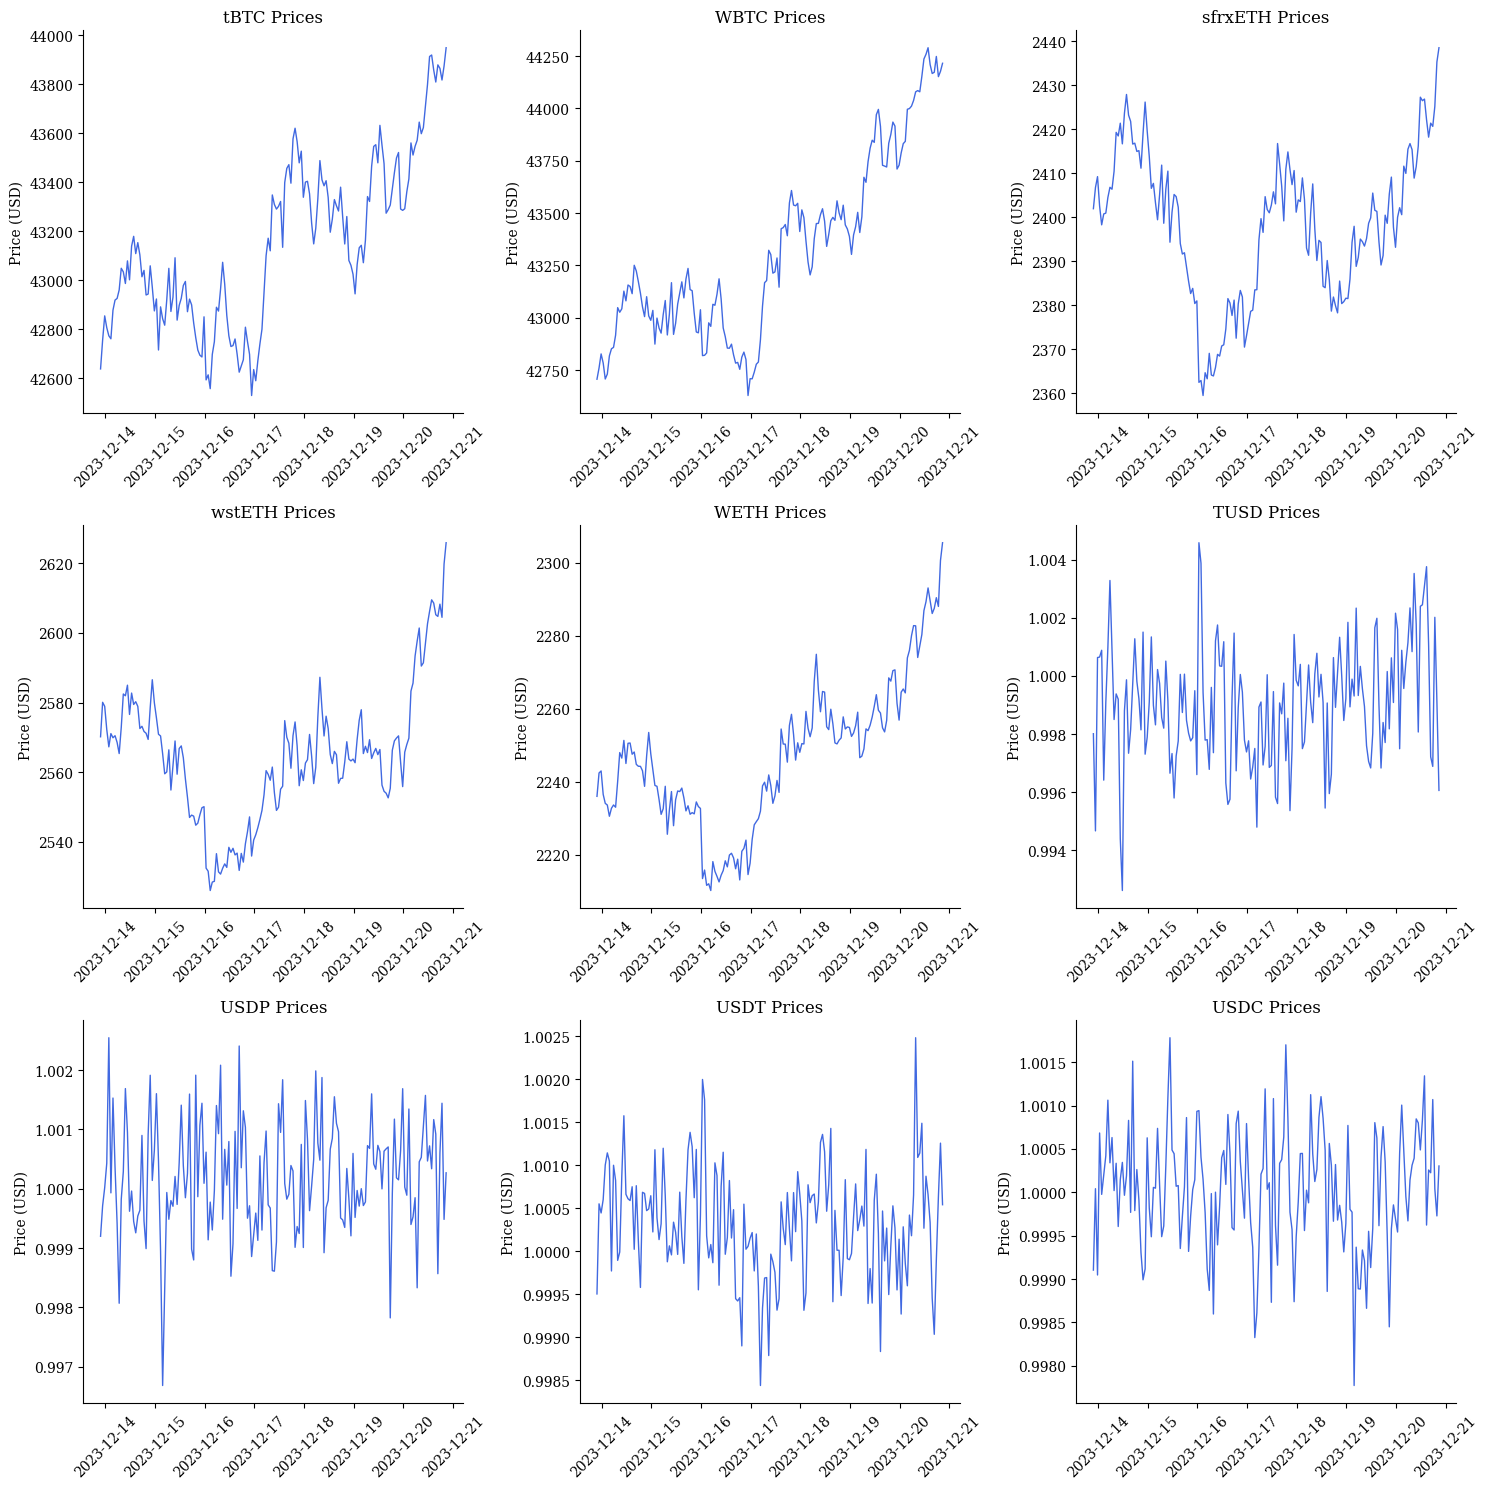

In [2]:
# Generate markets and prices
scenario = Scenario("baseline", "tbtc")
scenario.prepare_for_run()
_ = plot_prices(scenario.pricepaths.prices)
print(
    f"Running {scenario.num_steps} steps with frequency {scenario.pricepaths.config['freq']}."
)

In [3]:
metricsprocessor = MetricsProcessor(scenario)
metricsprocessor.initial_state

{'timestamp': Timestamp('2023-12-13 21:41:41'),
 'arbitrageur_profit': 0,
 'arbitrageur_count': 0,
 'keeper_profit': 0.0,
 'keeper_count': 0,
 'liquidator_profit': 0.0,
 'liquidator_count': 0,
 'llamma_tBTC_price': 42252254028532200125531,
 'llamma_tBTC_oracle_price': 42679053165217198374912,
 'llamma_tBTC_fees_x': 0,
 'llamma_tBTC_fees_y': 0,
 'llamma_tBTC_bal_x': 57289396071897166512128,
 'llamma_tBTC_bal_y': 131814897927551949920,
 'controller_tBTC_system_health': 5.909010963445989e+17,
 'controller_tBTC_bad_debt': 452682494451923984318464,
 'controller_tBTC_num_loans': 20,
 'controller_tBTC_debt': 3322236359180388250157056,
 'stableswap_crvUSD_TUSD_price': 1001185173844006844,
 'stableswap_crvUSD_TUSD_ma_price': 1001185173844006844,
 'stableswap_crvUSD_TUSD_lp_supply': 8986033406794928023655866,
 'stableswap_crvUSD_TUSD_virtual_price': 1000000000000000000,
 'stableswap_crvUSD_TUSD_TUSD_bal': 5654911706369908005931615,
 'stableswap_crvUSD_TUSD_crvUSD_bal': 3331763843801236206228639,

Text(0.5, 1.0, 'tbtc Loan Distribution')

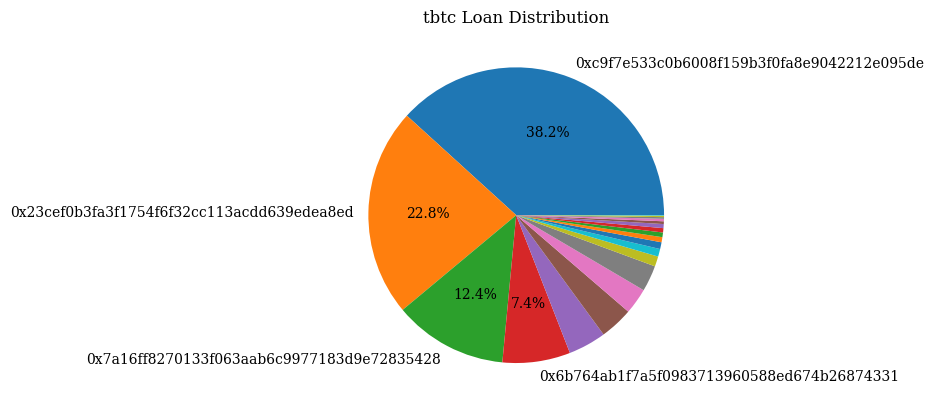

In [4]:
import matplotlib.pyplot as plt


def custom_autopct(pct):
    return "{:.1f}%".format(pct) if pct > 5 else ""


controller = scenario.controller
total_debt = 0
loans = {}
for user, loan in controller.loan.items():
    debt = loan.initial_debt / 1e18
    loans[user] = debt
    total_debt += debt

thresh = 0.05 * total_debt
loans = dict(sorted(loans.items(), key=lambda x: x[1], reverse=True))
labels = [a if loans[a] > thresh else "" for a in loans.keys()]
f, ax = plt.subplots()
pie = ax.pie(loans.values(), labels=labels, autopct=custom_autopct)
ax.set_title(f"{scenario.market_name} Loan Distribution")

### Run the Sim

In [5]:
for sample in scenario.pricepaths:
    scenario.prepare_for_trades(sample)  # update prices/timestamps
    scenario.perform_actions(sample)  # arbitrage, liquidate, update
    metricsprocessor.update()  # collect metrics

[INFO][21:41:48][src.agents.liquidator]-81440: There are 3 users to liquidate.
[INFO][21:41:48][src.agents.liquidator]-81440: Missed liquidation for user 0xea0a77dba85ad9a9c5d5c07f0d81f26826ad6bc3. Health: -152439002071075008.000000. Expected profit: -3431.850881.
[INFO][21:41:48][src.agents.liquidator]-81440: Missed liquidation for user 0xaf04017af941f3519902c75673ebbedad48acf58. Health: -532153149487538944.000000. Expected profit: -7823.622568.
[INFO][21:41:48][src.agents.liquidator]-81440: Liquidating user 0x7a16ff8270133f063aab6c9977183d9e72835428 with expected profit: 143136.895662.
[INFO][21:41:48][src.trades.cycle]-81440: Executing cycle Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=USDC, out=crvUSD, amt=362370156510), Liquidation(controller=<crvusdsim.pool.sim_interface.sim_controller.SimController object at 0x7f8e16788aa0>, position=<crvusdsim.pool.crvusd.controller.Position object at 0x7f8e0279dfd0>, amt=362558801452935137675599, frac=10000000000000000

[INFO][21:41:49][src.trades.cycle]-81440: No liquidity for Cycle(Trades: [Swap(pool=Curve.fi Stablecoin tBTC, in=tBTC, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=crvUSD, out=TUSD, amt=0), Swap(pool=External Market (TUSD, tBTC), in=TrueUSD, out=tBTC v2, amt=0)], Expected Profit: 0.0).
[INFO][21:41:49][src.trades.cycle]-81440: No liquidity for Cycle(Trades: [Swap(pool=Curve.fi Stablecoin tBTC, in=tBTC, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=crvUSD, out=USDC, amt=0), Swap(pool=External Market (tBTC, USDC), in=USD Coin, out=tBTC v2, amt=0)], Expected Profit: 0.0).
[INFO][21:41:49][src.agents.arbitrageur]-81440: Executing arbitrage: Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=USDC, out=crvUSD, amt=147410208830), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=crvUSD, out=TUSD, amt=147336780585096005708219), Swap(pool=External Market (TUSD, USDC), in=TrueUSD, out=USD Coin, amt=147267033102190

In [6]:
df = metricsprocessor.df
df.to_csv("../data/results.csv")
df.head()

,timestamp,arbitrageur_profit,arbitrageur_count,keeper_profit,keeper_count,liquidator_profit,liquidator_count,llamma_tBTC_price,llamma_tBTC_oracle_price,llamma_tBTC_fees_x,llamma_tBTC_fees_y,llamma_tBTC_bal_x,llamma_tBTC_bal_y,controller_tBTC_system_health,controller_tBTC_bad_debt,controller_tBTC_num_loans,controller_tBTC_debt,stableswap_crvUSD_TUSD_price,stableswap_crvUSD_TUSD_ma_price,stableswap_crvUSD_TUSD_lp_supply,stableswap_crvUSD_TUSD_virtual_price,stableswap_crvUSD_TUSD_TUSD_bal,stableswap_crvUSD_TUSD_crvUSD_bal,stableswap_crvUSD_USDP_price,stableswap_crvUSD_USDP_ma_price,stableswap_crvUSD_USDP_lp_supply,stableswap_crvUSD_USDP_virtual_price,stableswap_crvUSD_USDP_USDP_bal,stableswap_crvUSD_USDP_crvUSD_bal,stableswap_crvUSD_USDC_price,stableswap_crvUSD_USDC_ma_price,stableswap_crvUSD_USDC_lp_supply,stableswap_crvUSD_USDC_virtual_price,stableswap_crvUSD_USDC_USDC_bal,stableswap_crvUSD_USDC_crvUSD_bal,stableswap_crvUSD_USDT_price,stableswap_crvUSD_USDT_ma_price,stableswap_crvUSD_USDT_lp_supply,stableswap_crvUSD_USDT_virtual_price,stableswap_crvUSD_USDT_USDT_bal,stableswap_crvUSD_USDT_crvUSD_bal,pk_crvUSD/TUSD_debt,pk_crvUSD/TUSD_profit,pk_crvUSD/USDP_debt,pk_crvUSD/USDP_profit,pk_crvUSD/USDC_debt,pk_crvUSD/USDC_profit,pk_crvUSD/USDT_debt,pk_crvUSD/USDT_profit,aggregator_price,stablecoin_total_supply
0,2023-12-13 21:41:41,415.363634,1,0.0,0,143136.895662,1,41829731488246878124275,42679053165217198374912,198944775,7598,0,119925534529300822211,6.766202e+17,39331225270402070609920,19,2902388161655556144297182,1001185173844006844,1001185173844006844,8986033406794928023655866,1000000000000000000,5654911706369908005931615,3331763843801236206228639,999604756666680807,999604756666680807,3872639215983582736560919,1000000000000000000,1748177927110919066996794,2124498130954262865413514,999742583525203354,999332903740629188,35405470041822348091638870,1000002372703564860,16570464019999,18835235200577862228756420,999720969041227227,1000038570549498228,33397682634471741307330358,1000001972742544453,15542708229171,17855200856699327048874462,4580380907086699947132294,0,0,0,0,0,55469176741475060237970,0,999740527134941328,166288770404422310300684236
1,2023-12-13 22:41:41,3075.777335,4,0.0,0,143136.895662,1,42054862640078278863910,42755483634974932345802,199788144,7598,0,119925534529300822211,6.797294e+17,39331225270402070609920,19,2902388161687497505479940,1004414390353050715,1003510429828966507,8986033406794928023655866,1000007195639696715,6948141628852203448175199,2041757691755973221427244,999689585362679924,999688259382484444,3872639215983582736560919,1000000507915582106,1787509398361198398001210,2085154750629397606323083,999742583525203354,999736177506992936,35405470041822348091638870,1000002372703564860,16570464019999,18835235200577862228756420,999378980873800225,999454002302739594,33397682634471741307330358,1000003962537630108,14214085946359,19184483918269296778428378,4580380907086699947132294,0,0,0,0,0,55469176741475060237970,0,999620641466871176,167618053465992280030238152
2,2023-12-13 23:41:41,7370.991079,9,0.0,0,143136.895662,1,42345963572706852659967,42853907084317955816119,201031652,7598,0,119925534529300822211,6.837333e+17,39331225270402070609920,19,2902388161691729186287017,999486344333080791,1000919482344867285,8986033406794928023655866,1000023972324803689,3932699298218543800682142,5053691281066500041446027,999689585362679924,999689566514290764,3872639215983582736560919,1000000507915582106,1787509398361198398001210,2085154750629397606323083,1000433699831531888,1000092383211425903,35405470041822348091638870,1000006627091508915,19582956668467,15823150999526695818437610,999378980873800225,999380154938806506,33397682634471741307330358,1000003962537630108,14214085946359,19184483918269296778428378,4580380907086699947132294,0,0,0,0,0,55469176741475060237970,0,999827278138911893,170629987055302806850256935
3,2023-12-14 00:41:41,8033.830511,11,0.0,0,143136.895662,1,42209926869953920841717,42807968364760125962350,201813149,7598,0,11992

<Axes: >

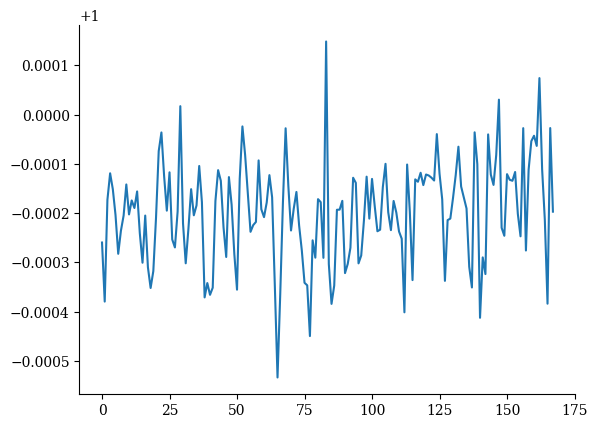

In [7]:
(df["aggregator_price"] / 1e18).plot()

<Axes: >

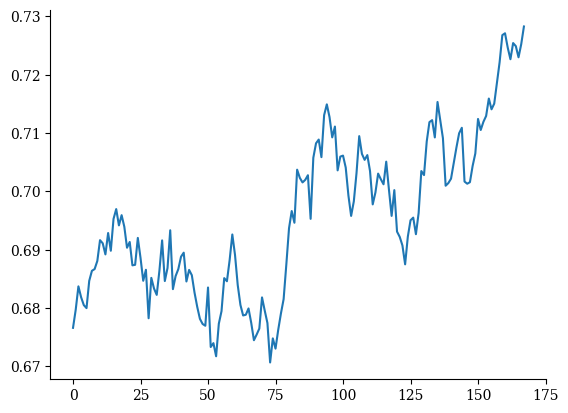

In [12]:
(df["controller_tBTC_system_health"] / 1e18).plot()

<Axes: >

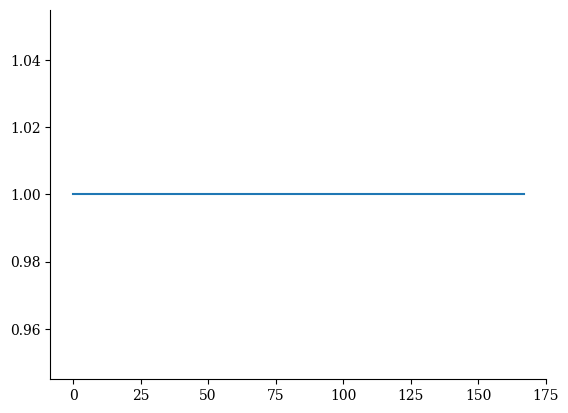

In [13]:
df["liquidator_count"].plot()

Notice that the above is a standard result from risk simulations: frequent, small liquidations actually *improve* the health of the system! 

In [14]:
(df["llamma_WETH_price"] / 1e18).plot(label="AMM Price")
(df["llamma_WETH_oracle_price"] / 1e18).plot(
    label="Oracle Price"
)  # = spot price for now
plt.legend()
# scenario.pricepaths.prices[SYMBOL_TO_ADDRESS["WETH"]].reset_index(drop=True).plot()

KeyError: 'llamma_WETH_price'

Text(0.5, 1.0, 'Profits sans t0')

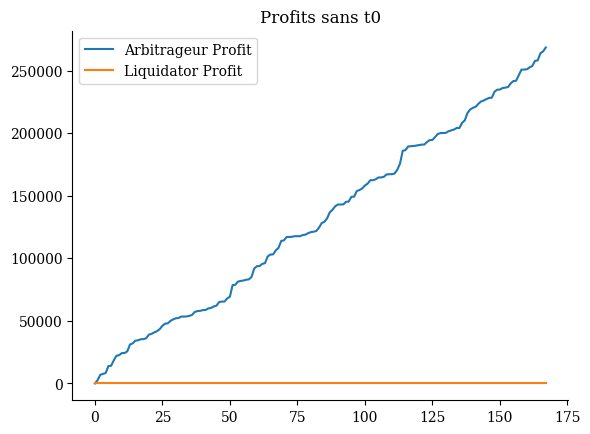

In [15]:
(df["arbitrageur_profit"] - df["arbitrageur_profit"].iloc[0]).plot(
    label="Arbitrageur Profit"
)
(df["liquidator_profit"] - df["liquidator_profit"].iloc[0]).plot(
    label="Liquidator Profit"
)
plt.legend()
plt.title("Profits sans t0")

<Axes: >

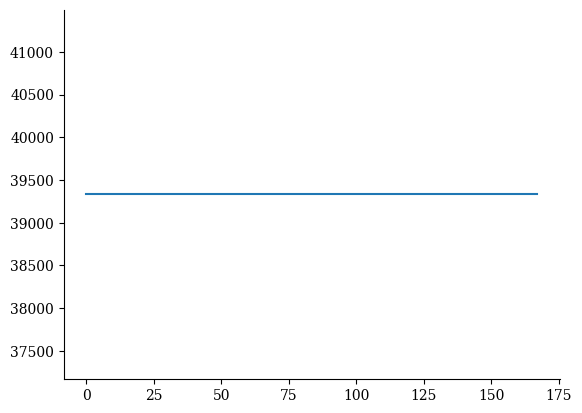

In [17]:
(df["controller_tBTC_bad_debt"] / 1e18).plot()

(1.0, 1.0005)

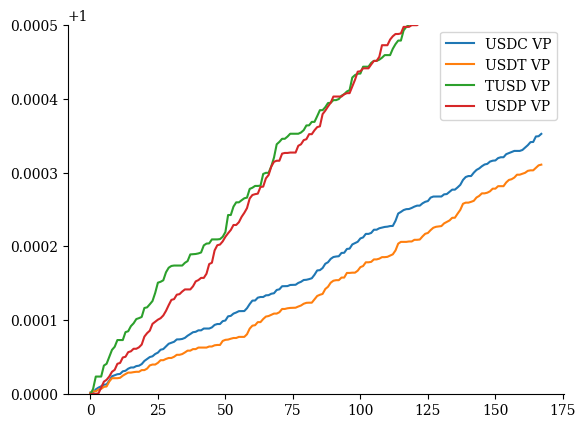

In [18]:
(df["stableswap_crvUSD_USDC_virtual_price"] / 1e18).plot(label="USDC VP")
(df["stableswap_crvUSD_USDT_virtual_price"] / 1e18).plot(label="USDT VP")
(df["stableswap_crvUSD_TUSD_virtual_price"] / 1e18).plot(label="TUSD VP")
(df["stableswap_crvUSD_USDP_virtual_price"] / 1e18).plot(label="USDP VP")
plt.legend()
plt.ylim(1, 1.0005)